# Group-level satistical analysis of brain electrical properties - Experiment n°4
This notebook presents the fourth experiment of the group level statistical analysis of brain electrical properties ($\sigma$ and $\epsilon_r$). In this experiment, we investigate the effect of prematurity on conductivity within deep gray matter (dGM) and white matter (WM) tissues. We defined preterm birth (PTB) as the number of weeks between age at birth (i.e. gestational age -- GA at birth) and the 37 week prematurity threshold ($\textrm{PTB} = 37 - \textrm{GA}$). We only included scans where PMA $\geq$ 37 weeks so that both term-born and preterm infants are considered at similar age at scan; $n = 534$ subjects were considered in total. 

Although local estimation of EPs from GRE, EPI and TSE sequences was limited by voxel size and partial volume effect, focusing on a median value for the tissue of interest greatly mitigates the effect of noise. For each subject, median $\sigma_{\textrm{dGM}}$ and $\sigma_{\textrm{WM}}$ were extracted from GRE, EPI and TSE scans using the dHCP tissue labels and then averaged using the inverse of the within-brain (voxel-wise) standard deviation for each measurement in each subject as weights. Similarly, median dGM and WM MD values were extracted from MD images using the available tissue segmentation. 

Analysis to this point considered brain average electrical properties (excluding CSF and ventricles), but it is expected that different tissue types would have distinct properties. It is also hypothesized that EPs might be affected by premature birth, as has been observed by other MRI studies measuring NMR relaxation properties.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import warnings

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy.stats import ttest_1samp, pearsonr
from matplotlib.ticker import FormatStrFormatter

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.stats import *
from utils.plots import *

sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")

## 1. Filter PMA, MD and RVV covariates
Remove subjects for which PMA < 37 weeks or MD was not available.

In [2]:
def filter_dHCP_df(input_df_path, output_df_path):
    # Remove NaN and PMA < 37
    df = pd.read_csv(input_df_path)
    df = df.dropna(subset=["brain_MD", "RVV"])
    df = df.drop(df[df["PMA"] < 37].index)
    df.to_csv(output_df_path, index=False)

In [3]:
# Set file path
csv_dir = os.path.join(base_dir, "data", "cohorts_csv")
unfiltered_df_path = os.path.join(csv_dir, "dHCP.csv")
df_path = os.path.join(csv_dir, "dHCP_filtered_MD_RVV_PMA.csv")

# Filter and load dataframe
filter_dHCP_df(unfiltered_df_path, df_path)
df = pd.read_csv(df_path) 

# Display cohort size
print(f"dHCP sessions n = {len(df.index)}")
print(f"dHCP subjects m = {df['subject_id'].nunique()}")

dHCP sessions n = 534
dHCP subjects m = 534


## 2. Comparison of dGM and WN neonatal conductivity measurements
Paired $\sigma_{\textrm{dGM}}$ $\sigma_{\textrm{WM}}$ and distributions were compared using Bland-Altman analysis to assess the systematic and proportional biases between tissue conductivities.

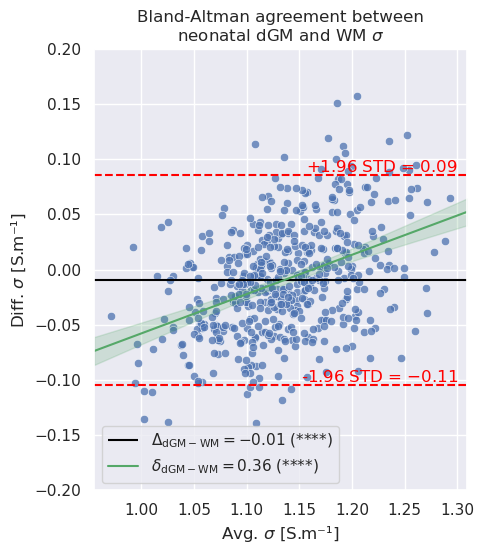

In [4]:
# Set file path
plot_dir = os.path.join(base_dir, "plots", "experiments")
plot_path = os.path.join(plot_dir, "experiment4A.png")

# Load dataframe
df = pd.read_csv(df_path)

# Data header
x_col = "SIG"
g1 = "dGM"
g2 = "WM"

# Compute average and difference
x1 = df[f"{g1}_{x_col}"]
x2 = df[f"{g2}_{x_col}"]
df["avg"] = (x1 + x2) / 2
df["diff"] = x1 - x2

# Axes limits with margin
xlim = calculate_plot_lim(df["avg"], coeff_margin=0.05)
ylim = (-0.2, 0.2)

# Initialize plot
fig, axes = plt.subplots(1, 1, figsize=(5.0,5.7))
axes.set_title("Bland-Altman agreement between\n"r"neonatal dGM and WM $\sigma$")

# Systematic bias
Delta = np.mean(df["diff"])
std = np.std(df["diff"])

# Fit linear model
formula = "diff ~ avg"
lm = smf.ols(formula=formula, data=df).fit()

# Confidence interval
X = np.linspace(xlim[0], xlim[1], num=100)
pred = lm.get_prediction({"avg": X})
pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals

# Plot data
sns.scatterplot(data=df, x="avg", y="diff", ax=axes, alpha=0.75)

# Label
ttest = ttest_1samp(df["diff"], 0)
pval = ttest.pvalue
var_symbol = rf"\Delta_{{\mathregular{{{g1}-{g2}}}}}"
label = f"${var_symbol} = {Delta:.2f}$ ({convert_pvalue_to_asterisks(pval)})"

# Systematic bias lines
axes.hlines(Delta, xlim[0], xlim[1], colors="black", label=label)
axes.hlines(Delta+1.96*std, xlim[0], xlim[1], colors="red", linestyles="dashed")
axes.hlines(Delta-1.96*std, xlim[0], xlim[1], colors="red", linestyles="dashed")

# Systematic bias lines label
pos = xlim[1] - 0.025 * (xlim[1] - xlim[0])
axes.text(pos, Delta+1.96*std, f"+1.96$\;$STD = ${Delta+1.96*std:.2f}$", c="red", ha="right", va="bottom")
axes.text(pos, Delta-1.96*std, f"-1.96$\;$STD = ${Delta-1.96*std:.2f}$", c="red", ha="right", va="bottom")

# Proportional bias label
delta = lm.params["avg"]
pval = lm.pvalues["avg"]
var_symbol = rf"\delta_{{\mathregular{{{g1}-{g2}}}}}"
label = f"${var_symbol} = {delta:.2f}$ ({convert_pvalue_to_asterisks(pval)})"

# Regression line and confidence interval
axes.plot(X, lm.params["Intercept"] + delta * X, color="g", label=label)
axes.fill_between(X, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color="g", alpha=0.2)

# Labels and limits
axes.set_xlabel(r"Avg. $\sigma$ [S.m⁻¹]")
axes.set_ylabel(r"Diff. $\sigma$ [S.m⁻¹]")
axes.set_xlim(xlim)
axes.set_ylim(ylim)

# Legend
axes.legend(loc="lower left")

# Adjust layout
fig.tight_layout()

# Save figure
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

The Bland-Altman analysis revealed a small but statistically significant systematic bias in conductivity estimates between dGM and WM ($\Delta_{\textrm{dGM–WM}} = -0.01\, [\textrm{S.m}^{-1}]$), indicating that WM was marginally more conductive than dGM. This finding contrasts with expected adult tissue values, where GM is typically more conductive than WM (e.g. at 128 MHz, $\sigma_{\textrm{GM}} = 0.59\, [\textrm{S.m}^{-1}]$ vs. $\sigma_{\textrm{WM}} = 0.34\, [\textrm{S.m}^{-1}]$; IT’IS database https://itis.swiss/virtual-population/tissue-properties/database/dielectric-properties/). One possible explanation is that partial volume effects, combined with extensive spatial smoothing during preprocessing, may have obscured fine-scale conductivity differences. Alternatively, the reduced contrast may reflect genuine biological properties of the neonatal brain, where tissue differentiation are still incomplete. Notably, a positive proportional bias ($\delta_{\textrm{dGM–WM}} = 0.36$) was observed, possibly indicating emerging tissue differentiation as development progresses.

## 3. Relationships between neonatal variables in both dGM and WM tissues
We evaluated the relationships between conductivity, PMA, PTB, MD and RVV in both tissues using Pearson's correlation coefficients $\rho_{XY}$.

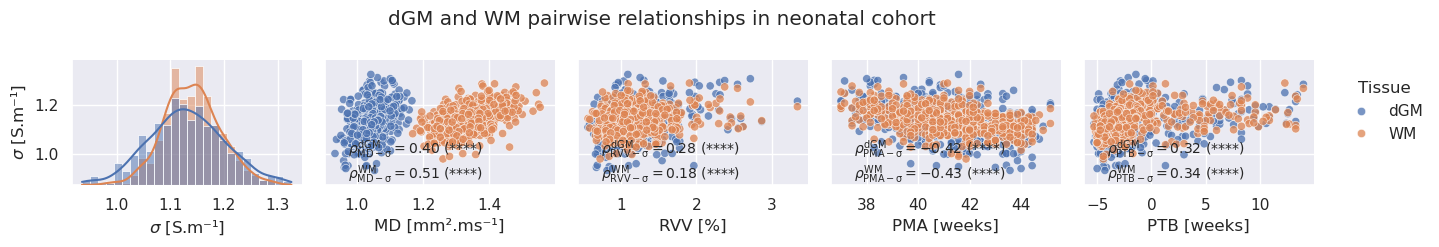

In [5]:
# Set file path
plot_path = os.path.join(plot_dir, "experiment4B.png")

# Load dataframe
df = pd.read_csv(df_path)

# Data header
x_cols = ["PMA", "PTB", "RVV"]
y_cols = ["SIG", "MD"]
tissue_col = "Tissue"
tissue_labels = ["dGM", "WM"]

# Build vertical dataframe
vert_df = []
for tissue in tissue_labels:
    temp_df = {}
    for x_col in x_cols:
        temp_df[x_col] = df[x_col].values
    for y_col in y_cols:
        temp_df[y_col] = df[f"{tissue}_{y_col}"].values
    temp_df[tissue_col] = tissue
    
    vert_df.append(pd.DataFrame(temp_df))

# Concatenate
vert_df = pd.concat(vert_df, ignore_index=True)

# Rename columns for plotting
vert_df = vert_df.rename(columns={
    "SIG": r"$\sigma$ [S.m⁻¹]",
    "MD": "MD [mm².ms⁻¹]",
    "RVV": "RVV [%]",
    "PMA": "PMA [weeks]",
    "PTB": "PTB [weeks]",
})

# Select x and y variables
x_vars = [
    r"$\sigma$ [S.m⁻¹]",
    "MD [mm².ms⁻¹]",
    "RVV [%]",
    "PMA [weeks]",
    "PTB [weeks]",
]
y_vars = [
    r"$\sigma$ [S.m⁻¹]",
]

# Initialize plot
g = sns.PairGrid(vert_df, hue=tissue_col, x_vars=x_vars, y_vars=y_vars)
g.fig.suptitle("dGM and WM pairwise relationships in neonatal cohort")

# Plot data
g.map_diag(sns.histplot, kde=True)
g.map_offdiag(sns.scatterplot, alpha=0.75)
g.map_offdiag(annotate_tissue_pairplot, tissue_labels=tissue_labels)

# Legend
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.75))

# Adjust layout
g.fig.tight_layout()

# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches="tight")

For both dGM and WM tissues, pairwise relationships showed that, $\sigma$ was significantly correlated with MD, RVV, PMA and PTB. As expected, conductivity decreases with age in both tissues, while water content (MD) is a key driver of conductivity in both tissues, slightly stronger for WM. We found that $\rho_{\sigma-\textrm{RVV}}^{\textrm{dGM}} > \rho_{\sigma-\textrm{RVV}}^{\textrm{WM}}$, suggesting that dGM is more affected by the propagation of high conductivity CSF artefact than WM tissue. This may be explained by the proximity of dGM and ventricles. Finally, preterm birth is positively associated with higher conductivity, suggesting delayed maturation in both tissues.

## 4. Effect of prematurity on conductivity within dGM and WM tissues

### 4.a. Multivariate mixed-effects statistical analysis
A multivariate LME model was fitted to the neonatal $\sigma_{\textrm{dGM}}$ and $\sigma_{\textrm{WM}}$ conductivity values with MD, RVV, PTB and PMA as explanatory variables. The model integrated mixed-effects to account for the interdependence of $\sigma_{\textrm{dGM}}$ and $\sigma_{\textrm{WM}}$ measurements performed on the same subjects and included interaction terms between tissue type and all predictor variables. Proportional effect coefficients were also computed and reported at tissue level.

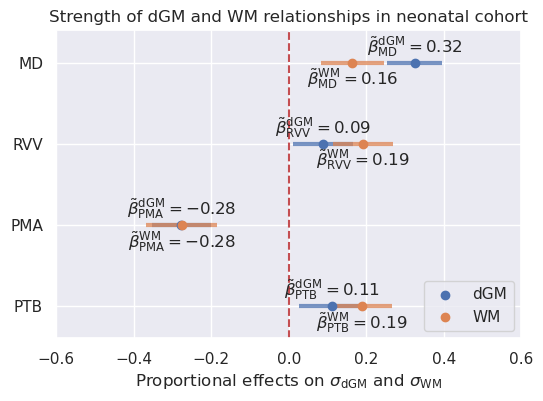

In [6]:
# Set file path
summary_dir = os.path.join(base_dir, "statsmodels")
plot_path = os.path.join(plot_dir, "experiment4C.png")
summary_path = os.path.join(summary_dir, "experiment4C.txt")

# Load dataframe
df = pd.read_csv(df_path) 

# Data header
x_cols = ["PTB", "PMA", "RVV", "MD"]
y_col = "SIG"
var_cols = ["PMA", "PTB", "RVV"]
var_tissue_cols = ["SIG", "MD"]
tissue_col = "Tissue"
tissue_labels = ["dGM", "WM"]
groups_col = "subject_id"

# Center data
for var_col in var_cols:
    df[var_col] -= df[var_col].mean()
for tissue in tissue_labels:
    for var_tissue_col in var_tissue_cols:
        if var_tissue_col != y_col:
            df[f"{tissue}_{var_tissue_col}"] -= df[f"{tissue}_{var_tissue_col}"].mean()

# Build vertical datafrane
vert_df = []
for tissue in tissue_labels:
    temp_df = {}
    for var_col in var_cols:
        temp_df[var_col] = df[var_col].values
    for var_tissue_col in var_tissue_cols:
        temp_df[var_tissue_col] = df[f"{tissue}_{var_tissue_col}"].values
    temp_df[tissue_col] = tissue
    temp_df[groups_col] = df[groups_col]
    vert_df.append(pd.DataFrame(temp_df))

# Concatenate
vert_df = pd.concat(vert_df, ignore_index=True)

# Fit mixed effects model
x_str = []
for x_col in x_cols:
    x_str += [f"{x_col} + C(Tissue)*{x_col} - {x_col}"]
formula = f"SIG ~ {' + '.join(x_str)} + C(Tissue) - 1"
lme = smf.mixedlm(formula=formula, data=vert_df, groups=vert_df[groups_col]).fit(reml=False)

# Coefficient of determination
marginal_r2, conditional_r2 = lme_coefficient_determination(lme, vert_df)

# Normalize data
for var_col in var_cols:
    df[var_col] /= df[var_col].std()
for tissue in tissue_labels:
    for var_tissue_col in var_tissue_cols:
        if var_tissue_col != y_col:
            df[f"{tissue}_{var_tissue_col}"] /= df[f"{tissue}_{var_tissue_col}"].std()
        else:
            df[f"{tissue}_{y_col}"] = (df[f"{tissue}_{y_col}"] - df[f"{tissue}_{y_col}"].mean()) / df[f"{tissue}_{y_col}"].std()

# Build vertical dataframe
vert_df = []
for tissue in tissue_labels:
    temp_df = {}
    for var_col in var_cols:
        temp_df[var_col] = df[var_col].values
    for var_tissue_col in var_tissue_cols:
        temp_df[var_tissue_col] = df[f"{tissue}_{var_tissue_col}"].values
    temp_df[tissue_col] = tissue
    temp_df[groups_col] = df[groups_col]
    vert_df.append(pd.DataFrame(temp_df))

# Concatenate
vert_df = pd.concat(vert_df, ignore_index=True)

# Fit mixed effects model (proportional effects)
lme_prop = smf.mixedlm(formula=formula, data=vert_df, groups=vert_df[groups_col]).fit(reml=False)

# Coefficients of determination
marginal_r2_prop, conditional_r2_prop = lme_coefficient_determination(lme_prop, vert_df)

# Labels
n = len(tissue_labels)
m = len(x_cols)
xlim = [-.6, .6]
ylim = [-0.4, 3.4]
palette = sns.color_palette()
yticks = ["PTB", "PMA", "RVV", "MD"]

# Initialize plot
fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.set_title("Strength of dGM and WM relationships in neonatal cohort")

# Iter over tissue
for i, tissue in enumerate(tissue_labels):
    # Plot effects
    params = lme_prop.params[n+i:-1:n]
    ax.scatter(params, range(m), zorder=2, color=palette[i], label=tissue)

    # Iter over predictors
    for idx, ci in enumerate(lme_prop.conf_int().loc[params.index].iterrows()):
        # Add the confidence interval error bars
        ax.hlines(idx, ci[1][0], ci[1][1], color=palette[i], zorder=1, linewidth=3, alpha=0.75)

        # Label
        va = "top" if i else "bottom"
        y = idx - 0.05 if i else idx + 0.05
        a = rf"\tilde{{\beta}}_{{\mathregular{{{yticks[idx]}}}}}^{{\mathregular{{{tissue}}}}}"
        ax.text(params[idx], y, f"${a} = {params[idx]:.2f}$", va=va, ha="center")

# Add dashed line at 0.0
plt.axline((0,0), (0,1), color="r", linestyle="--") 

# Axis labels and linits
ax.set_yticks(range(m), yticks)
ax.set_xlabel(r"Proportional effects on $\sigma_{\mathregular{dGM}}$ and $\sigma_{\mathregular{WM}}$")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Legend
ax.legend(loc="lower right")

# Initialize output directories
for path in [summary_path, plot_path]:
    output_dir = os.path.dirname(path)
    os.makedirs(output_dir, exist_ok=True)
    
# Save plot
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    
# Write summary
with open(summary_path, "w") as fh:
    fh.write(lme.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2:.2f}, Conditional R² = {conditional_r2:.2f}\n\n")
    fh.write(lme_prop.summary().as_text())
    fh.write(f"\nMarginal R² = {marginal_r2_prop:.2f}, Conditional R² = {conditional_r2_prop:.2f}\n\n")

In [7]:
# Model summary
f = open(summary_path, 'r')
file_contents = f.read()
print(file_contents)
f.close()

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   SIG      
No. Observations:    1068      Method:               ML       
No. Groups:          534       Scale:                0.0010   
Min. group size:     2         Log-Likelihood:       1780.2301
Max. group size:     2         Converged:            Yes      
Mean group size:     2.0                                      
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
C(Tissue)[WM]       1.141    0.002 515.348 0.000  1.136  1.145
C(Tissue)[dGM]      1.131    0.002 511.078 0.000  1.127  1.136
C(Tissue)[WM]:PTB   0.001    0.001   2.089 0.037  0.000  0.003
C(Tissue)[dGM]:PTB  0.003    0.001   5.335 0.000  0.002  0.005
C(Tissue)[WM]:PMA  -0.008    0.001  -5.938 0.000 -0.011 -0.005
C(Tissue)[dGM]:PMA -0.011    0.002  -6.449 0.000 -0.014 -0.007
C(Tis

Multivariate mixed-effects linear regression using PMA, PTB, MD and RVV as predictor variables found similar significant associations with PMA for dGM ($\beta^{\textrm{dGM}}_{\textrm{PMA}} = -0.011 \pm 0.002, [\textrm{S.m}^{-1}\textrm{week}^{-1}]$) and WM ($\beta^{\textrm{WM}}_{\textrm{PMA}} = -0.008 \pm 0.001, [\textrm{S.m}^{-1}\textrm{week}^{-1}]$), consistent with brain average values quoted previously. Additionally, significant associations with PTB were also observed, particularly in dGM where $\beta^{\textrm{dGM}}_{\textrm{PTB}} = 0.003 \pm 0.001, [\textrm{S.m}^{-1}\textrm{week}^{-1}]$. Analysis of the proportional effect coefficients in each tissue revealed that MD had the largest effect size on $\sigma_{\textrm{WM}}$ while PMA had the greatest relationship with $\sigma_{\textrm{dGM}}$ ($\tilde{\beta}^{\textrm{WM}}_{\textrm{MD}} = 0.32$, $\textit{p} < 0.0001$; $\tilde{\beta}^{\textrm{dGM}}_{\textrm{PMA}} = -0.28$, $\textit{p} < 0.0001$). Hence, while observed conductivity falls with post-menstrual age, there is a positive association with prematurity: preterm birth is associated with a delay in the normal changes in conductivity observed over this period. 

### 4.b Partial correlations
For both dGM and WM tissues, partial correlation coefficients $\rho_{XY \cdot \textbf{Z}}$ were computed using the residuals $e(X|\textbf{Z})$ and $e(Y|\textbf{Z})$ that were obtained by respectively fitting LME models on $X$ and $Y$ variables with $\textbf{Z}$ as predictors. We used these to assess the strength of the relationship between the two variables while controlling the effect of confounding variables.

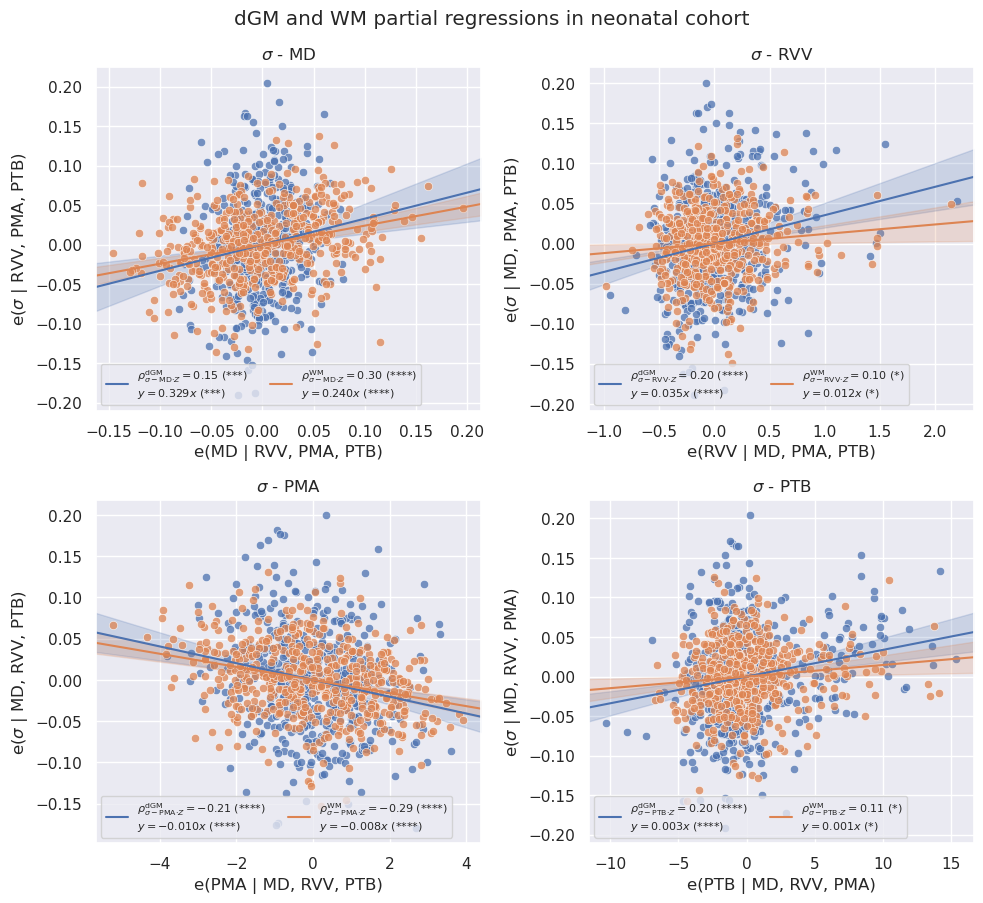

In [8]:
# Set file path
plot_path = os.path.join(plot_dir, "experiment4D.png")

# Load dataframe
df = pd.read_csv(df_path) 

# Data header
x_cols = ["MD", "RVV", "PMA", "PTB"]
y_col = "SIG"
var_tissue_cols = ["MD"]
tissue_labels = ["dGM", "WM"]
y_label = r"$\sigma$"
n = len(x_cols)

# Color palette for plotting
palette = sns.color_palette()

# Initialize plot
fig, axes = plt.subplots(2, 2, figsize=(10, 9.2))
fig.suptitle("dGM and WM partial regressions in neonatal cohort")

# Iter over predictors
for i, x_col in enumerate(x_cols):

    # Axis limit
    xlim = [[],[]]

    # iter over tissues
    for j, tissue in enumerate(tissue_labels):
        # Control variables
        z_cols = [z_col for z_col in x_cols if z_col != x_col]

        # Partial regression on x
        x_res_col = f"{tissue}_{x_col}_residual"
        z_str = []
        for z_col in z_cols:
            if z_col in var_tissue_cols:
                z_str += [f"{tissue}_{z_col}"]
            else:
                z_str += [z_col]
        x_str = x_col if x_col not in var_tissue_cols else f"{tissue}_{x_col}"
        formula = f"{x_str} ~  {' + '.join(z_str)}"
        lm = smf.ols(formula=formula, data=df).fit()
        df[x_res_col] = lm.resid

        # Axis limit with margin
        temp_xlim = calculate_plot_lim(df[x_res_col], coeff_margin=0.05)
        xlim[0] += [temp_xlim[0]]
        xlim[1] += [temp_xlim[1]]

    # Axis limit
    xlim[0] = min(xlim[0])
    xlim[1] = max(xlim[1])

    # Subplot index
    l, k = i//2, i%2

    # Iter over tissues
    for j, tissue in enumerate(tissue_labels):

        # Partial regression on x 
        x_res_col = f"{tissue}_{x_col}_residual"

        # Partial regression on y
        y_res_col = f"{tissue}_{y_col}_residual"
        z_str = []
        for z_col in z_cols:
            if z_col in var_tissue_cols:
                z_str += [f"{tissue}_{z_col}"]
            else:
                z_str += [z_col]
        y_str = f"{tissue}_{y_col}"
        formula = f"{y_str} ~  {' + '.join(z_str)}"
        lm = smf.ols(formula=formula, data=df).fit()
        df[y_res_col] = lm.resid

        # Fit linear model on residuals
        formula = f"{y_res_col} ~  {x_res_col}"
        lm = smf.ols(formula=formula, data=df).fit()

        # Confidence interval
        X = np.linspace(xlim[0], xlim[1], num=100)
        pred = lm.get_prediction({x_res_col: X})
        pred_summary = pred.summary_frame(alpha=0.05)  # 95% confidence intervals

        # Plot data
        sns.scatterplot(ax=axes[l,k], data=df, x=x_res_col, y=y_res_col, alpha=0.75)

        # Label
        slope = lm.params[x_res_col]
        slope_pval = lm.pvalues[x_res_col]
        rho, pval = pearsonr(df[x_res_col], df[y_res_col])
        var_symbol = rf"\rho_{{\sigma-\mathregular{{{x_cols[i]}}}·Z}}^{{\mathregular{{{tissue}}}}}"
        label = (f"${var_symbol} = {rho:.2f}$ ({convert_pvalue_to_asterisks(pval)})\n"
                 f"$y = {slope:.3f}x$ ({convert_pvalue_to_asterisks(slope_pval)})")
        
        # Regression line and confidence interval
        axes[l,k].plot(X, lm.params["Intercept"] + slope * X, color=palette[j], label=label)
        axes[l,k].fill_between(X, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color=palette[j], alpha=0.2)

    # Title, axis label and limits
    axes[l,k].set_title(f"{y_label} - {x_col}")  
    axes[l,k].set_xlabel(f"e({x_cols[i]} | {', '.join([x_cols[j] for j in range(n) if j != i])})")
    axes[l,k].set_ylabel(f"e({y_label} | {', '.join([x_cols[j] for j in range(n) if j != i])})")
    axes[l,k].set_xlim(xlim)

    # Legend
    axes[l,k].legend(loc="lower left", ncols=2,  prop={'size': 8})
    
# Adjust layout
fig.tight_layout()
    
# Save plot
output_dir = os.path.dirname(plot_path)
os.makedirs(output_dir, exist_ok=True)
plt.savefig(plot_path, bbox_inches='tight', dpi=300)

Partial correlations confirmed the presence of a residual correlation between $\sigma$ and PMA within dGM and WM tissues when controlling for the confounding effects of MD, RVV and PTB ($\rho_{\sigma-\textrm{PMA} \cdot \textbf{Z}}^{\textrm{dGM}} = -0.21$, $\textit{p} < 0.0001$; $\rho_{\sigma-\textrm{PMA} \cdot \textbf{Z}}^{\textrm{WM}} = -0.29$, $\textit{p} < 0.0001$). A similar conclusion can be reached for $\sigma$-PTB relationships ($\rho_{\sigma-\textrm{PTB}\cdot \textbf{Z}}^{\textrm{dGM}} = 0.20$, $\textit{p} < 0.0001$; $\rho_{\sigma-\textrm{PTB} \cdot \textbf{Z}}^{\textrm{WM}} = 0.11$, $\textit{p} < 0.05$). Interestingly, the partial correlations showed that the $\sigma$-PMA association is stronger in WM than in dGM when controlling for the other variables, while the opposite is true for the relationship between $\sigma$ and PTB. It was also apparent that MD significantly explains $\sigma$ in both tissues, slightly more in dGM. Finally, RVV affects dGM significantly more than WM which are possible CSF-related effects. Overall, the differential effects between dGM and WM support the use of independent tissue models, rather than assuming global conductivity values.